In [1]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib  #ajustar
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import backend as K
import idx2numpy
import csv

import import_ipynb
from utils import *
from autoencoder_and_clustering_models import *

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from autoencoder_and_clustering_models.ipynb


In [2]:
def read_preprocess_dataset( indexes_train, indexes_val = np.empty(0)):

    file = 'D:\\Luiza\\OneDrive\\Documentos\\Doutorado\\MeusProjetos\\cifar_10_kmeans\\train-images-idx3-ubyte\\train-images.idx3-ubyte'
    img_train_val = idx2numpy.convert_from_file(file)

    file = 'D:\\Luiza\\OneDrive\\Documentos\\Doutorado\\MeusProjetos\\cifar_10_kmeans\\t10k-images-idx3-ubyte\\t10k-images.idx3-ubyte'
    img_test = idx2numpy.convert_from_file(file)

    file = 'D:\\Luiza\\OneDrive\\Documentos\\Doutorado\\MeusProjetos\\cifar_10_kmeans\\train-labels-idx1-ubyte\\train-labels.idx1-ubyte'
    target_train_val = idx2numpy.convert_from_file(file)

    file = 'D:\\Luiza\\OneDrive\\Documentos\\Doutorado\\MeusProjetos\\cifar_10_kmeans\\t10k-labels-idx1-ubyte\\t10k-labels.idx1-ubyte'
    target_test = idx2numpy.convert_from_file(file)
    
    
    indexes_train = indexes_train.astype(int)
    indexes_val = indexes_val.astype(int)
    
    data_train_val = np.expand_dims(img_train_val, axis=3)
    data_test = np.expand_dims(img_test, axis=3)

    data_train_val = data_train_val/255
    data_test = data_test/255
    
    
    if indexes_val.size==0:
        data_train = data_train_val
        target_train = target_train_val
        
        return data_train, data_test, target_train, target_test
    
    else:
        data_train = data_train_val[indexes_train]
        target_train = target_train_val[indexes_train]
        
        data_val = data_train_val[indexes_val]
        target_val = target_train_val[indexes_val]
        
        return data_train, data_val, data_test, target_train, target_val, target_test
    
    

In [3]:
model = model_encoder(input_shape=(28,28,1), n_classes = 10)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
AC_0 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 28, 28, 32)        128       
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 14, 14, 16)        12816     
_________________________________________________________________
AC_1 (Activation)            (None, 14, 14, 16)        0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 14, 14, 16)        6

In [4]:
def train_evaluate(n_epoch, b_size, arq_path, list_indexes):

    
    train_mse = np.zeros((5))
    val_mse = np.zeros((5))
    
    for i_crossVal in range(5):

        
        
        i_train = np.array([w for w in range(5) if not w == i_crossVal])
        
        indexes_val = list_indexes[i_crossVal]
        indexes_train = np.empty(0)
        for i in range(len(i_train)):
            indexes_train = np.concatenate ((indexes_train, list_indexes[i_train[i]]), axis=0 )
        indexes_val = np.array(indexes_val)
        indexes_train = np.array(indexes_train)
        
        data_train, data_val, data_test, label_train, label_val, label_test = read_preprocess_dataset( indexes_train, indexes_val ) 


        input_shape = (data_train.shape[1],data_train.shape[2],data_train.shape[3])
        model = model_encoder(input_shape=input_shape, n_classes=10)
        
        # Train


        arq_model=arq_path + '\\Encoder_model_'+str(i_crossVal)+'.h5'
        checkpoint =  tf.keras.callbacks.ModelCheckpoint(
        arq_model, 
        monitor='val_loss', 
        mode='min',
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False,
      
        )
        opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
       # opt = tf.keras.optimizers.Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07 )
        model.compile(loss = 'mse', optimizer=opt)
    #    model.compile(loss='mse', optimizer=opt)
        history = model.fit(x=data_train, y=data_train, validation_data=(data_val, data_val), batch_size=b_size, epochs=n_epoch, callbacks=[checkpoint])
    #    model.save(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Mean Squared Error')
        plt.xlabel('Epoch')
  #      plt.yscale('log')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(arq_path + '\Encoder_TrainHistory_loss_'+str(i_crossVal)+'.jpg')
        plt.show()
        
       
        model = tf.keras.models.load_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5')
        train_mse[i_crossVal] = model.evaluate(x=data_train, y=data_train, batch_size=b_size)
        val_mse[i_crossVal] = model.evaluate(x=data_val, y=data_val, batch_size=b_size)
        
  #      train_loss[i_crossVal] = model.evaluate(x=data_train, y=data_train, batch_size=b_size)
  #      val_loss[i_crossVal] = model.evaluate(x=data_val, y=data_val, batch_size=b_size)
        
    train_mse_mean = np.mean(train_mse)
    val_mse_mean = np.mean(val_mse)
    
    train_mse_std = np.std(train_mse)
    val_mse_std = np.std(val_mse)
    
       
    
    print('The Mean Train MSE for the Cross-Validation = ', train_mse_mean, ' - with Standard Deviation = ', train_mse_std)
    print('The Mean Validation MSE for the Cross-Validation = ', val_mse_mean, ' - with Standard Deviation = ', val_mse_std)
    
 

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 119s 2ms/sample - loss: 0.0420 - val_loss: 0.0290
Epoch 2/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0255 - val_loss: 0.0230
Epoch 3/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0216 - val_loss: 0.0199
Epoch 4/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0196 - val_loss: 0.0185
Epoch 5/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0183 - val_loss: 0.0176
Epoch 6/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0174 - val_loss: 0.0169
Epoch 7/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0168 - val_loss: 0.0166
Epoch 8/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0162 - val_loss: 0.0157
Epoch 9/100
48000/48000 [==============================] - 136s 3ms/sample - l

48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0105 - val_loss: 0.0108
Epoch 76/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0105 - val_loss: 0.0109
Epoch 77/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0104 - val_loss: 0.0110
Epoch 78/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0104 - val_loss: 0.0107
Epoch 79/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0104 - val_loss: 0.0108
Epoch 80/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0104 - val_loss: 0.0108
Epoch 81/100
48000/48000 [==============================] - 137s 3ms/sample - loss: 0.0104 - val_loss: 0.0108
Epoch 82/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0103 - val_loss: 0.0107
Epoch 83/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0103 - val_loss: 0.0108
Epoch 84/100
48000/4800

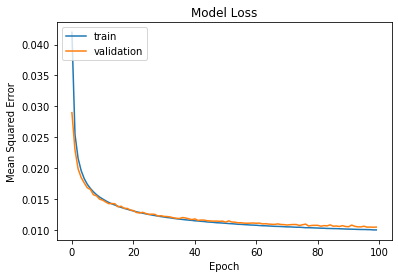

12000/12000 [==============================] - 10s 839us/sample - loss: 0.0105
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 137s 3ms/sample - loss: 0.0478 - val_loss: 0.0316
Epoch 2/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0269 - val_loss: 0.0240
Epoch 3/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0229 - val_loss: 0.0218
Epoch 4/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0208 - val_loss: 0.0197
Epoch 5/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0193 - val_loss: 0.0185
Epoch 6/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0182 - val_loss: 0.0176
Epoch 7/100
48000/48000 [==============================] - 137s 3ms/sample - loss: 0.0174 - val_loss: 0.0170
Epoch 8/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0167 - val_loss: 0.0170

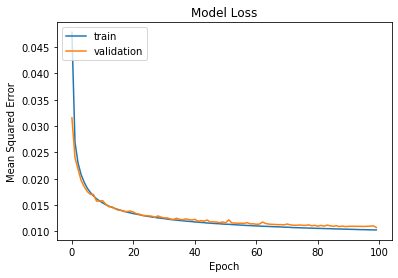

12000/12000 [==============================] - 10s 840us/sample - loss: 0.0108
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 137s 3ms/sample - loss: 0.0361 - val_loss: 0.0255
Epoch 2/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0231 - val_loss: 0.0214
Epoch 3/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0202 - val_loss: 0.0199
Epoch 4/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0187 - val_loss: 0.0179
Epoch 5/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0176 - val_loss: 0.0171
Epoch 6/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0168 - val_loss: 0.0164
Epoch 7/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0162 - val_loss: 0.0161
Epoch 8/100
48000/48000 [==============================] - 136s 3ms/sample - loss: 0.0157 - val_loss: 0.0156

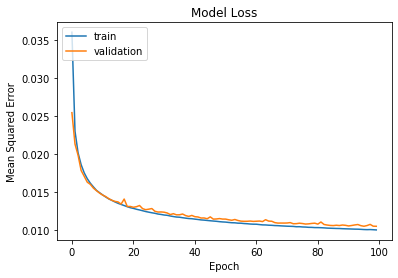

12000/12000 [==============================] - 10s 861us/sample - loss: 0.0106
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 138s 3ms/sample - loss: 0.0372 - val_loss: 0.0272
Epoch 2/100
48000/48000 [==============================] - 138s 3ms/sample - loss: 0.0243 - val_loss: 0.0219
Epoch 3/100
48000/48000 [==============================] - 137s 3ms/sample - loss: 0.0211 - val_loss: 0.0201
Epoch 4/100
48000/48000 [==============================] - 138s 3ms/sample - loss: 0.0192 - val_loss: 0.0183
Epoch 5/100
48000/48000 [==============================] - 138s 3ms/sample - loss: 0.0180 - val_loss: 0.0173
Epoch 6/100
48000/48000 [==============================] - 52s 1ms/sample - loss: 0.0171 - val_loss: 0.0169
Epoch 7/100
48000/48000 [==============================] - 37s 773us/sample - loss: 0.0165 - val_loss: 0.0163
Epoch 8/100
48000/48000 [==============================] - 37s 767us/sample - loss: 0.0159 - val_loss: 0.015

48000/48000 [==============================] - 168s 4ms/sample - loss: 0.0104 - val_loss: 0.0107
Epoch 74/100
48000/48000 [==============================] - 35s 721us/sample - loss: 0.0104 - val_loss: 0.0107
Epoch 75/100
48000/48000 [==============================] - 65s 1ms/sample - loss: 0.0103 - val_loss: 0.0109
Epoch 76/100
48000/48000 [==============================] - 137s 3ms/sample - loss: 0.0103 - val_loss: 0.0108
Epoch 77/100
48000/48000 [==============================] - 135s 3ms/sample - loss: 0.0103 - val_loss: 0.0110
Epoch 78/100
48000/48000 [==============================] - 97s 2ms/sample - loss: 0.0103 - val_loss: 0.0107
Epoch 79/100
48000/48000 [==============================] - 68s 1ms/sample - loss: 0.0103 - val_loss: 0.0108
Epoch 80/100
48000/48000 [==============================] - 137s 3ms/sample - loss: 0.0103 - val_loss: 0.0107
Epoch 81/100
48000/48000 [==============================] - 130s 3ms/sample - loss: 0.0103 - val_loss: 0.0106
Epoch 82/100
48000/48000 

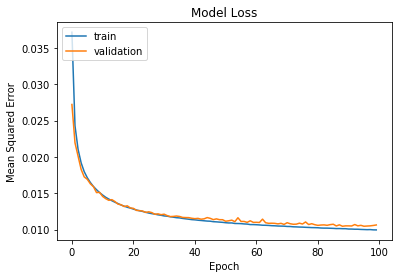

12000/12000 [==============================] - 3s 237us/sample - loss: 0.0105
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 40s 833us/sample - loss: 0.0412 - val_loss: 0.0280
Epoch 2/100
48000/48000 [==============================] - 41s 854us/sample - loss: 0.0255 - val_loss: 0.0228
Epoch 3/100
48000/48000 [==============================] - 42s 870us/sample - loss: 0.0217 - val_loss: 0.0203
Epoch 4/100
48000/48000 [==============================] - 40s 841us/sample - loss: 0.0198 - val_loss: 0.0186
Epoch 5/100
48000/48000 [==============================] - 38s 800us/sample - loss: 0.0185 - val_loss: 0.0177
Epoch 6/100
48000/48000 [==============================] - 53s 1ms/sample - loss: 0.0177 - val_loss: 0.0172
Epoch 7/100
48000/48000 [==============================] - 48s 994us/sample - loss: 0.0169 - val_loss: 0.0164
Epoch 8/100
48000/48000 [==============================] - 44s 917us/sample - loss: 0.0164 - val_loss: 0

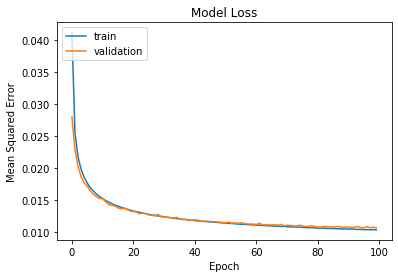

12000/12000 [==============================] - 6s 468us/sample - loss: 0.0107s - l
The Mean Train MSE for the Cross-Validation =  0.009886453404836357  - with Standard Deviation =  0.00013211767931431716
The Mean Validation MSE for the Cross-Validation =  0.010591011251757543  - with Standard Deviation =  0.00011507302077616474


In [5]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\\mnist'

file = 'D:\\Luiza\\OneDrive\\Documentos\\Doutorado\\MeusProjetos\\cifar_10_kmeans\\train-images-idx3-ubyte\\train-images.idx3-ubyte'
img_train_val = idx2numpy.convert_from_file(file)
    
k_folds = 5
indexes = np.arange(len(img_train_val))
np.random.shuffle(indexes)
end_sublist = 0
list_indexes = []
for i in range (k_folds):
    begin_sublist = end_sublist
    end_sublist = int( (i+1) * len(img_train_val)/k_folds) 
    list_indexes.append(list( indexes[begin_sublist:end_sublist] ))
                
with open(arq_path+"_crossValidation_indexes.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(list_indexes)
    
del img_train_val


train_evaluate(n_epoch=100, b_size=32, arq_path = arq_path, list_indexes=list_indexes)

<Figure size 432x288 with 0 Axes>

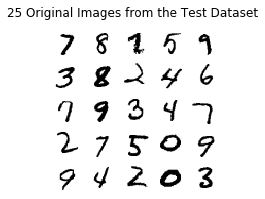

<Figure size 432x288 with 0 Axes>

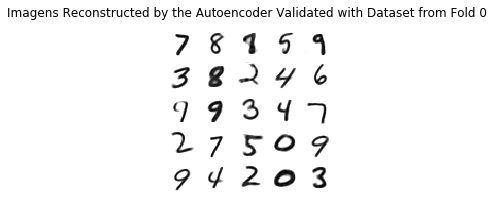

10000/10000 [==============================] - 2s 225us/sample - loss: 0.0105


<Figure size 432x288 with 0 Axes>

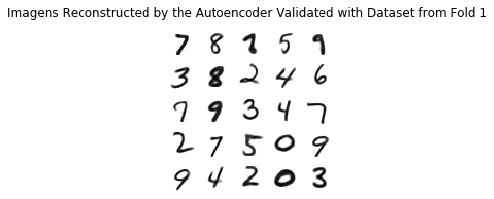

10000/10000 [==============================] - 2s 222us/sample - loss: 0.0106


<Figure size 432x288 with 0 Axes>

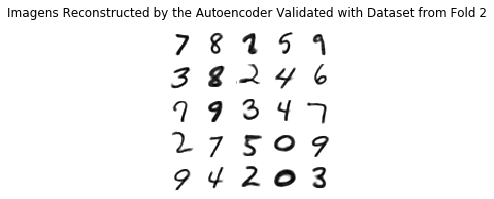

10000/10000 [==============================] - 2s 227us/sample - loss: 0.0104


<Figure size 432x288 with 0 Axes>

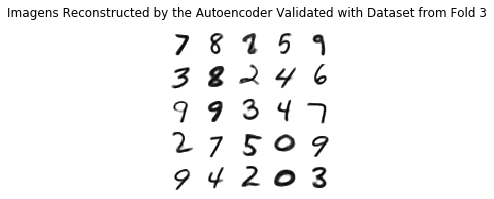

10000/10000 [==============================] - 2s 225us/sample - loss: 0.0104


<Figure size 432x288 with 0 Axes>

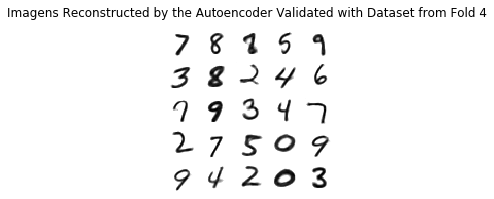

10000/10000 [==============================] - 2s 224us/sample - loss: 0.0108

The Mean Test MSE for the Cross-Validation = 0.01052  - with Standard Deviation = 0.00015


In [7]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\mnist'

with open(arq_path+"\crossValidation_indexes.csv", newline='') as f:
    list_indexes = csv.reader(f)
    list_indexes = list(list(rec) for rec in csv.reader(f, delimiter=','))
(np.array(list_indexes)).astype(int)


i_crossVal = 0
i_train = np.array([w for w in range(5) if not w == i_crossVal])
indexes_val = list_indexes[i_crossVal]
indexes_train = np.empty(0)
for i in range(len(i_train)):
    indexes_train = np.concatenate ((indexes_train, list_indexes[i_train[i]]), axis=0 )
indexes_val = np.array(indexes_val)
indexes_train = np.array(indexes_train)
        
data_train, data_val, data_test, label_train, label_val, label_test = read_preprocess_dataset( indexes_train, indexes_val ) 



i = np.random.choice(range(len(data_test)),25)

t=0
plt.figure()
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
i_aux=np.zeros((5,5))
for j in range(5):
    for k in range(5):
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(np.squeeze(data_test[i[t]]), cmap=plt.cm.binary)
        t+=1
fig.suptitle('25 Original Images from the Test Dataset')
plt.savefig(arq_path + '\examples_originalImagens.jpg', bbox_inches='tight')
plt.show()  
    
test_mse = np.zeros((5))

for i_crossVal in range(5):
    
   
    model = tf.keras.models.load_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5')
    
        
    y_hat=model.predict( data_test[i] )

    t=0
    plt.figure()
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(np.squeeze(y_hat[t]), cmap=plt.cm.binary)
            t+=1
    fig.suptitle('Imagens Reconstructed by the Autoencoder Validated with Dataset from Fold ' + str(i_crossVal))
    plt.savefig(arq_path + '\examples_ReconstructedImagens_NN'+str(i_crossVal)+'.jpg', bbox_inches='tight')
    plt.show()
    test_mse[i_crossVal] = model.evaluate(x=data_test, y=data_test, batch_size=128)
            
test_mse_mean = np.mean(test_mse)
test_mse_std = np.std(test_mse)


print('\nThe Mean Test MSE for the Cross-Validation = %.5f' % test_mse_mean, ' - with Standard Deviation = %.5f' % test_mse_std)

       
